# Bone Cancer
## Question of Interest

The aim of this project is to build a model that can predict the location of cancer based on the genetic data of the patient: in particular, whether it is present in bone tissue.

## Executive Summary

Cancer patient data was imported from the ICGC online database. Feature engineering and machine learning were employed in an attempt to classify the location of cancer (specifically, whether it was present in bone tissue or not). The presence of certain mutations common to bone cancer sufferers was used to attempt to predict donors' cancer location.

It was found that the presence of these mutations is not correlated with cancer location sufficiently to support a machine learning classification model, as shown by the reduced-dimensional data plot below.

![](https://user-images.githubusercontent.com/47208622/269920275-0fad7a15-44ff-4535-9566-72fb3425b406.png)

## Preparing the Data
### Importing the Data

In [1]:
import icgc
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Parse the JSON string into a Python list
data_list = json.loads(
    icgc.query(request_type="donors",pql='select(id,primarySite),limit(1000000)')
)
df = pd.DataFrame(data_list)

### Inspecting the Data

In [2]:
df["primarySite"].value_counts()

primarySite
Blood             3186
Brain             2504
Breast            1970
Liver             1840
Kidney            1551
Head and neck     1505
Prostate          1419
Lung              1200
Stomach           1173
Nervous System    1105
Pancreas          1072
Colorectal        1041
Esophagus          877
Skin               753
Ovary              727
Uterus             565
Bladder            515
Bone               341
Gall Bladder       310
Mesenchymal        307
Cervix             307
Nasopharynx         21
Name: count, dtype: int64

In [3]:
donorIDs_boneCancer = df["id"][df["primarySite"] == "Bone"].to_list()
donorIDs_otherCancer = df["id"][df["primarySite"] != "Bone"].to_list()
all_donors = df["id"]

### Retrieving mutation data for DNA donors

In [4]:
# in() function does not appear to work the same way as eq(), and no information is available online on how to use it
# therefore, a loop will be required
data_list = json.loads(
    icgc.query(request_type="occurrences",pql='select(donorId,mutationId),eq(donorId,"' + donorIDs_boneCancer[0] + '"),limit(10000000)')
)
df_occurrences = pd.DataFrame(data_list)
df_occurrences = df_occurrences.drop(['genes','observations'], axis=1)

for donor_id in tuple(donorIDs_boneCancer[1:]):
    # Code to be executed for each element
    # Get the occurrences
    data_list = json.loads(
        icgc.query(request_type="occurrences",pql='select(donorId,mutationId),eq(donorId,"' + donor_id + '"),limit(10000000)')
    )
    df_occurrences_iteration = pd.DataFrame(data_list)
    try:
        df_occurrences_iteration = df_occurrences_iteration.drop(['genes','observations'], axis=1)
        df_occurrences = df_occurrences.merge(df_occurrences_iteration,how='outer')
    except:
        if (df_occurrences_iteration.size > 0):
            raise Exception('Error merging results. Some rows missed.')
    #df_occurrences
df_occurrences
#df_indexed = df.set_index('id')
#df_indexed

,donorId,mutationId
0,DO52613,MU92544784
1,DO52613,MU92459802
2,DO52613,MU92245768
3,DO52613,MU92215581
4,DO52613,MU92253091
...,...,...
248767,DO994,MU197
248768,DO944,MU2188404
248769,DO50479,MU28809201
248770,DO967,MU1385


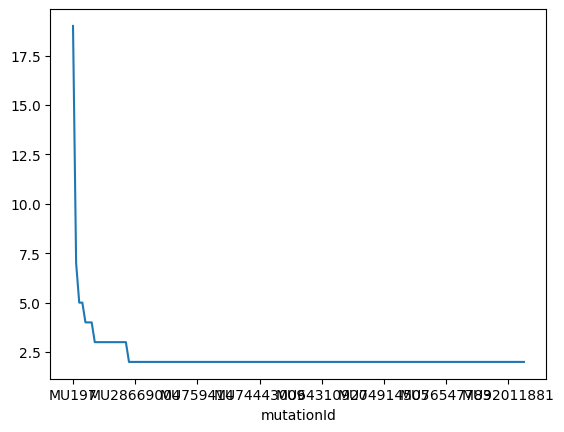

In [5]:
(df_occurrences["mutationId"].value_counts()[(df_occurrences["mutationId"].value_counts() >= 2)]).plot();

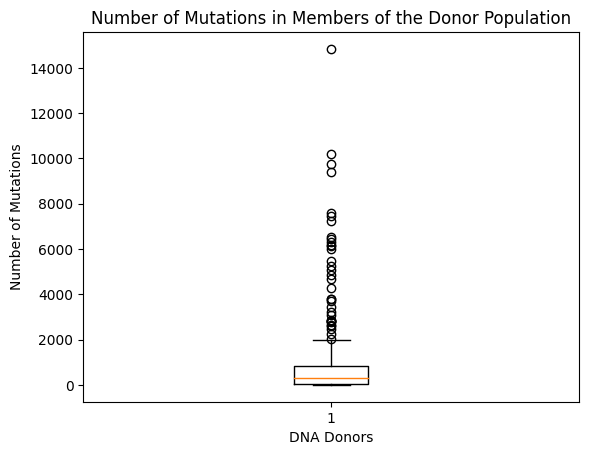

In [6]:
# ; suppresses unwanted text output
plt.boxplot(df_occurrences["donorId"].value_counts());
plt.xlabel("DNA Donors")
plt.ylabel("Number of Mutations")
plt.title("Number of Mutations in Members of the Donor Population");

In [7]:
mutations_of_interest = (df_occurrences["mutationId"].value_counts()[(df_occurrences["mutationId"].value_counts() >= 2)].index)
len(mutations_of_interest)

146

### Feature Engineering
Each mutation will be its own column of binary values, with '1' indicating the mutation is present, and '0' indicating it is not.

In [8]:
data = pd.DataFrame(np.zeros([len(all_donors),len(mutations_of_interest.tolist())+2]),columns=["donorId"]+["Target"]+mutations_of_interest.tolist())
data["donorId"] = all_donors
data["Target"] = (df["primarySite"] == "Bone").astype(int)
for mutation in mutations_of_interest:
    data_list = json.loads(
        icgc.query(request_type="occurrences",pql='select(donorId,mutationId),eq(mutationId,"' + mutation + '"),limit(100000)')
    )
    data[mutation] = [1 if item in pd.DataFrame(data_list)["donorId"].tolist() else 0 for item in all_donors]
data

,donorId,Target,MU197,MU99,MU272,MU74368039,MU23138892,MU91706760,MU28547779,MU885,...,MU75059795,MU92469482,MU91979135,MU28725954,MU92011881,MU75038996,MU28472843,MU91827587,MU30679646,MU921
0,DO232761,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,DO232224,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,DO222843,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,DO222837,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,DO50970,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24284,DO46091,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24285,DO231055,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24286,DO46275,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24287,DO45647,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


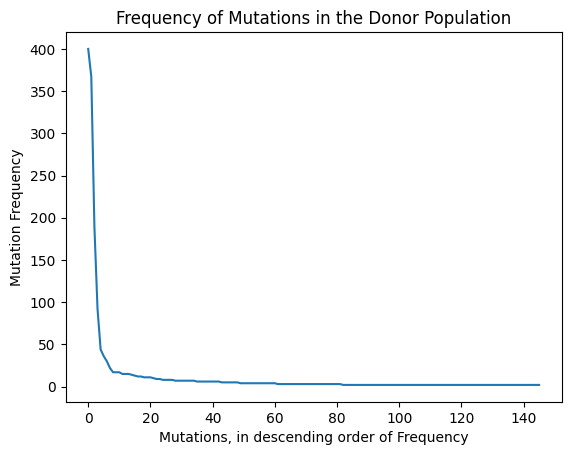

In [9]:
mutation_sums = []

for mutation in mutations_of_interest:
    mutation_sums.append(sum(data[mutation]))

mutation_sums.sort(reverse=True)

# ; suppresses unwanted text output
plt.plot(mutation_sums);
plt.xlabel("Mutations, in descending order of Frequency")
plt.ylabel("Mutation Frequency")
plt.title("Frequency of Mutations in the Donor Population");

Note that the number of mutations that only appear once in the population of bone cancer sufferers is far larger than the number that appear at least twice

### Visualising the features to get a sense of their predictive ability

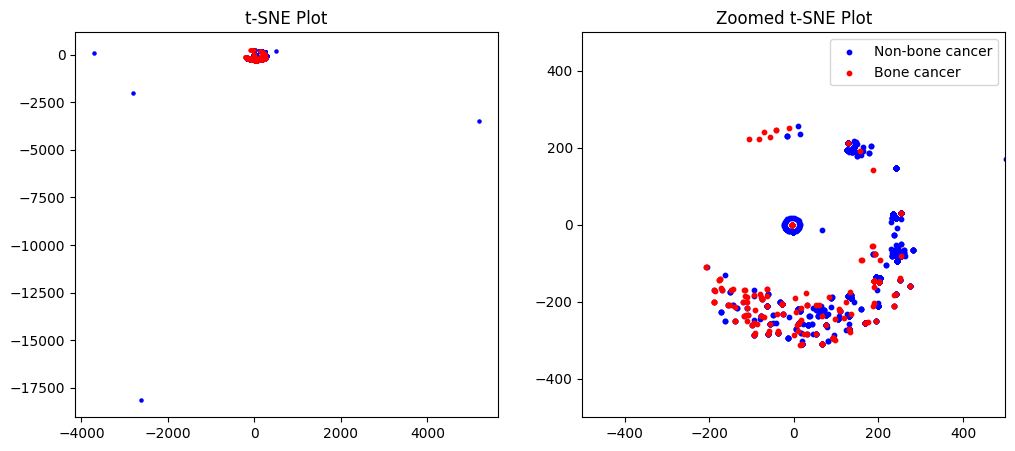

In [10]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Reduce dimensionality using t-SNE or PCA
# Assuming X is your feature matrix
tsne = TSNE(n_components=2)
pca = PCA(n_components=2)
X_tsne = tsne.fit_transform(data[mutations_of_interest])

# Create scatter plots of the reduced-dimensional data
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)

# Scatter plot for Class 0 (Non-bone cancer)
plt.scatter(X_tsne[data['Target'] == 0, 0], X_tsne[data['Target'] == 0, 1], c='b', s=5, label="Non-bone cancer")

# Scatter plot for Class 1 (Bone cancer)
plt.scatter(X_tsne[data['Target'] == 1, 0], X_tsne[data['Target'] == 1, 1], c='r', s=5, label="Bone cancer")

plt.title('t-SNE Plot')

plt.subplot(1, 2, 2)

# Scatter plot for Class 0 (Non-bone cancer)
plt.scatter(X_tsne[data['Target'] == 0, 0], X_tsne[data['Target'] == 0, 1], c='b', s=10, label="Non-bone cancer")

# Scatter plot for Class 1 (Bone cancer)
plt.scatter(X_tsne[data['Target'] == 1, 0], X_tsne[data['Target'] == 1, 1], c='r', s=10, label="Bone cancer")

plt.xlim(-500, 500)
plt.ylim(-500, 500)
plt.legend()
plt.title('Zoomed t-SNE Plot')

plt.show()

Unfortunately there isn't really any other usable data to go off for predicting whether a donor has cancer in one area or the other. It seems that bone cancer sufferers' data points are so closely intermingled with non-bone cancer donors, that it will not be possible to meaningfully predict the location of their cancer from their genetic mutations alone.

I have proceeded with the model anyway, and the results confirm my hypothesis.

## Creating a machine learning model
### Setting up the model

In [11]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=150, min_samples_split=2000, random_state=1)

In [12]:
import random

Target1Samples = random.sample(list(data[data['Target'] == 1].index),k=171)
Target0Samples = random.sample(list(data[data['Target'] == 0].index),k=11974)

# inverse as in (eg) 'those of Target == 1 that were not picked', not as in 'the true inverse of each of the two selections above'
Target1Samples_inverse = list(set(data[data['Target'] == 1].index) - set(Target1Samples))
Target0Samples_inverse = list(set(data[data['Target'] == 0].index) - set(Target0Samples))

data.iloc[Target1Samples+Target0Samples]


,donorId,Target,MU197,MU99,MU272,MU74368039,MU23138892,MU91706760,MU28547779,MU885,...,MU75059795,MU92469482,MU91979135,MU28725954,MU92011881,MU75038996,MU28472843,MU91827587,MU30679646,MU921
19505,DO932,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2543,DO52639,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8758,DO50530,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9180,DO50570,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19829,DO234041,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13617,DO19693,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9692,DO231287,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5722,DO228085,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18255,DO224831,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Create a train and test set
train = data.iloc[Target1Samples+Target0Samples]
test = data.iloc[Target1Samples_inverse+Target0Samples_inverse]

model.fit(train[mutations_of_interest], train["Target"])

RandomForestClassifier(min_samples_split=2000, n_estimators=150, random_state=1)

### Testing the model

In [14]:
# Evaluate accuracy of predictions
preds = model.predict(test[mutations_of_interest])
preds = pd.Series(preds, index=test.index)
print('Correctly predicted', sum(preds==test["Target"]),  '/', len(preds), '(', round(100*sum(preds==test["Target"])/len(preds),1) ,'% )' ', of which', sum(preds == 1), 'were identified as bone cancer patients.')
print('There were', sum(preds[preds == 1] == test['Target'][preds == 1]), 'True Positives,', sum(preds[preds == 1] != test['Target'][preds == 1]), 'False Positives,', sum(preds[preds == 0] == test['Target'][preds == 0]), 'True Negatives, and', sum(preds[preds == 0] != test['Target'][preds == 0]), 'False Negatives')

Correctly predicted 11967 / 12144 ( 98.5 % ), of which 21 were identified as bone cancer patients.
There were 7 True Positives, 14 False Positives, 11960 True Negatives, and 163 False Negatives


### Visualising the model

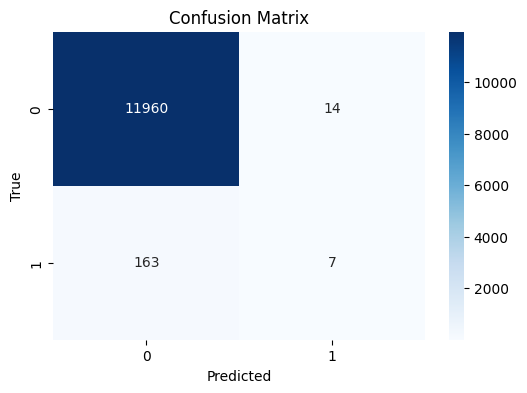

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming y_true contains true labels and y_pred contains predicted labels
cm = confusion_matrix(test["Target"], preds)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix");

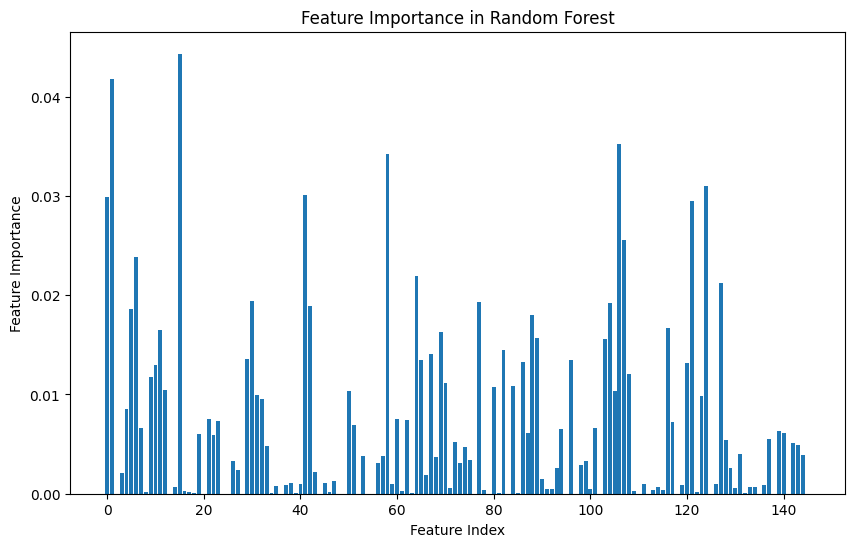

In [16]:
plt.figure(figsize=(10, 6))
# for 146 variables
plt.bar(range(146), model.feature_importances_)
plt.xlabel("Feature Index")
plt.ylabel("Feature Importance")
plt.title("Feature Importance in Random Forest");

I suspect that the highly degree of variability in the utility of mutations in predicting donor cancer site classification is because some mutations are far more common than others. 